# MiSec ML Use Case Demo
This Jupyter notebook walks through a basic Machine Learning classification use case with meta data derived from a labeled set of PowerShell logs.  You will need Scikit-learn, matplotlib, and numpy installed.  Code can be ran using Canopy (https://www.enthought.com/product/canopy/), in a Docker jupyter/datascience-notebook (https://hub.docker.com/r/jupyter/datascience-notebook/), or any other environment with the required packages.

The methodology presented has been ported from https://machinelearningmastery.com/machine-learning-in-python-step-by-step/.  After the data has been processed this is essentially the "hello world" of classification problems.

In [2]:
import re, math 
from collections import Counter
import numpy as np
from sklearn import cross_validation
from sklearn import model_selection
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC


/opt/conda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Import Data
Predictors2.txt contains calculated PowerShell metadata and a label that indicates whether the sample is malicious or benign.  There are 7 columns of data in a CSV format that indicate the uppercase/lowercase ratio, special character to total character ratio, alpha character to total character ratio, cosine similarity score, count of suspicious modules, count of malicious modules, and label.  The cosine similarity was implemented in python but the idea came from Lee Holmes at http://www.leeholmes.com/blog/2016/10/22/more-detecting-obfuscated-powershell/.  The specific module considered suspicious/malicious were derived using analyst judgement after reviewing a large quantity of events.  These two predictors are hand engineered and were ultimately removed for a better methodology of generating vocabulary frequency counts.  As predictors they worked very well but required ongoing maintenance which is not what we want when implementing an ML use case.  The last column is the label with 0 representing a benign record and 1 representing a suspicious record.

In [3]:
my_data = np.genfromtxt('predictors2.txt', delimiter=',', usecols= (0,1,2,3,4,5,6))

## Generate Train/Test/Validation data
Traning/testing and validation data are required before we start experimenting with various models.  We need to split the data into a train and validation set of predictors and a train and validation set of labels.  The training set will be used for testing various models to determine which model is the most accurate.  The validation set will be used to test the data on previously unseen data in order to determine whether the training model is overfitting the data or whether the training set does not closely represent the entire population of events.  The output shows an example of the predictors and label.

In [4]:
# predictors
X = my_data[:, 0:6]
print(X[1,:])

#Label
y = my_data[:,6]
print(y[1])

#generate train and validation data sets
validation_size = 0.20
seed = 7
X_train, X_validation, Y_train, Y_validation = model_selection.train_test_split(X, y, test_size=validation_size, \
                                                                                random_state=seed)

[ 1.77272727  0.17355372  0.25206612  0.36063873  0.          0.        ]
1.0


## Model Definitions
Each model and model label are added to a list which will be used for accuracy evaluation.  

In [5]:
# Build Models
models = []
models.append(('RF', RandomForestClassifier()))
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))

# evaluate each model in turn
results = []
names = []

## Model Evaluation
Each model is evaluated for accuracy using 10 fold validation.  The output shows the average score and standard deviation of the scores.  RF and KNN algorithm are very similar in accuracy most often the most accurate with the test data.

### Accuracy
Accuracy is one evaluation criteria that shows what percentage of true positves and true negatives were predicted correctly.  (True Positive + True Negative)/Total Events=Accuracy.  This appears to be very good but our data is very skewed towards events that are not suspicious so a high accuracy could still be very bad.  If we guessed everything was benign we would still have an accuracy of almost 93%.

In [6]:
scoring = 'accuracy'

for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=seed)
    cv_results = model_selection.cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

RF: 0.996402 (0.002062)
LR: 0.987858 (0.004741)
LDA: 0.975266 (0.006053)
KNN: 0.997302 (0.002621)
CART: 0.995728 (0.002347)
NB: 0.973472 (0.005103)
SVM: 0.987634 (0.005438)


## Visualize Results
Below is a box plot that shows the accuracy results of the various algorithms.  The scale is limited to an accuracy of 96% and above so all of the algorithms were fairly accurate.  

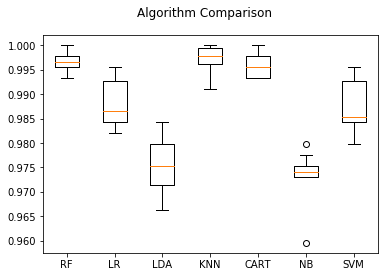

In [7]:
# Compare Algorithms
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

### Precision
Precision shows what percentage of positive (suspicious events) predictions were truely suspicious out of all the positive predictions.  This can help us determine how much trust to put in positive predictions but it doesn't tell us how many times it misses a positive prediction (false negative).  This metric answers the question: What percentage of suspicoius classifications are truely suspicious.


True Positive/(True Positive + False Positive) = Precision

In [10]:
scoring = 'precision'

for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=seed)
    cv_results = model_selection.cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

RF: 0.982129 (0.022188)
LR: 0.966582 (0.037036)
LDA: 0.816453 (0.071596)
KNN: 0.975818 (0.025927)
CART: 0.946119 (0.058327)
NB: 0.693118 (0.052446)
SVM: 0.980486 (0.031000)


### Recall
Recall helps determine how much we can trust the algorithm to catch all suspicious events.  This metric answers the questions: What percentage of truely suspicious events were classified as suspicious.

True Positive/(True Positive + False Negative) = Recall

In [11]:
scoring = 'recall'

for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=seed)
    cv_results = model_selection.cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

RF: 0.963723 (0.034175)
LR: 0.791953 (0.083966)
LDA: 0.663084 (0.077516)
KNN: 0.975433 (0.034415)
CART: 0.963723 (0.034175)
NB: 0.848044 (0.067814)
SVM: 0.775720 (0.098513)


## F1
The F1 score is a scoring metric that takes both recall and precision into consideration.  If you need a good mix of precision and recall then this is a good choice.

F1 = 2 * ((precision * recall)/(precision + recall))

In [12]:
scoring = 'f1'

for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=seed)
    cv_results = model_selection.cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

RF: 0.972752 (0.022402)
LR: 0.867563 (0.052916)
LDA: 0.728654 (0.058884)
KNN: 0.975165 (0.022398)
CART: 0.949604 (0.033379)
NB: 0.761196 (0.047634)
SVM: 0.862240 (0.064523)


## Evaluate Validation Set
The algorithm needs to be tested on a set of data that it wasn't trained on to get a more realistic accuracy number.  Earlier 20% of the data was set aside for validation and the accuracy is shown below.  

### Confusion Matrix
The confusion matrix is a common way to present machine learning classification data.  In binary classification this will look like a 2x2 matrix.  The first row shows the count of truely benign events and the second row shows count of truely suspicous events.  The first column represents the quantity of benign predictions and the second column shows the predicted suspicious events.  Moving clockwise from the upper left we have true positive, false positive, true negative, false negative.

In [13]:
# Make Predictions
# Make predictions on validation dataset
rf = RandomForestClassifier()
rf.fit(X_train, Y_train)
predictions = rf.predict(X_validation)
print(confusion_matrix(Y_validation, predictions))
print(accuracy_score(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

[[1056    1]
 [   3   53]]
0.996406109614
             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00      1057
        1.0       0.98      0.95      0.96        56

avg / total       1.00      1.00      1.00      1113



## Make Predictions
Making predictions is easy.  Just pass the event metadata to rf.predict and the model will output a 0 for benign and 1 for suspicious.  You can see a sample record from the validation set, the predicted output from the algorithm, and the true outcome from the labeled validation set.

In [31]:
print(X_validation[1])
print(rf.predict(X_validation[1].reshape(1,-1)))
print(Y_validation[1])

[ 0.22764228  0.140625    0.58984375  0.7865722   0.          0.        ]
[ 0.]
0.0


## Vectorization
The values that were used to determine the Suspicious/Malicious module count had to be update to get good results on the validation set and increse the recall score.  This is not optimal since it will need to be updated manually over time.  A better solution is to vectorize the PowerShell events and generate a vocabulary that can be used as a large quantity of predictors.  The machine learning algorithm can take this data, learn, and weight terms to determine which terms typically represent suspicious events and which represent malicious events.

In [10]:
from sklearn.feature_extraction.text import CountVectorizer
sample = ['the', 'the quick', 'the quick brown', 'the quick brown fox', 'john', 'the the']
vec = CountVectorizer()
data = vec.fit_transform(sample).toarray()
print(vec.vocabulary_)
print(data)


{'the': 4, 'quick': 3, 'brown': 0, 'fox': 1, 'john': 2}
[[0 0 0 0 1]
 [0 0 0 1 1]
 [1 0 0 1 1]
 [1 1 0 1 1]
 [0 0 1 0 0]
 [0 0 0 0 2]]
